In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
result_dir = "/mnt/kostas-graid/datasets/vlongle/diffphys3d/render_outputs/c017d0fb746d4cc48748cca76ad1efad"
# result_dir = "render_outputs/f420ea9edb914e1b9b7adebbacecc7d8/"

In [4]:
alphas = np.load(f"{result_dir}/clip_features_alphas.npy")
grid_feature_path = f"{result_dir}/clip_features.npz"
feature_result = np.load(grid_feature_path)

In [5]:

print("scene bounds", feature_result['min_bounds'], feature_result['max_bounds'])

scene bounds [-0.5 -0.5 -0.5] [0.5 0.5 0.5]


In [6]:
print("density:", np.max(alphas), np.min(alphas), np.mean(alphas))

density: 1.0 0.0 0.05328


In [7]:
## The point cloud is a sparse representation of the voxel grid. 
# Created by just getting the non-empty voxels via `alpha_threshold` (density threshold). 
# Then remove the gray background via `gray_threshold`.
ply_path = f"{result_dir}/clip_features_pc.ply"

In [8]:
import trimesh
pc = trimesh.load(ply_path)
points = np.asarray(pc.vertices)
colors = np.asarray(pc.colors)

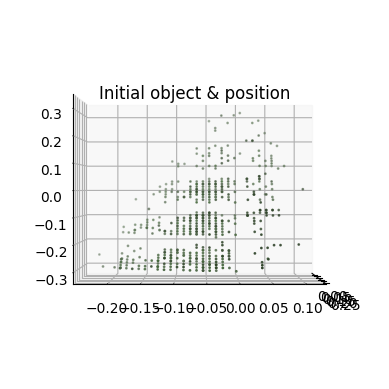

In [9]:
# Visualize initial object & position
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if colors.max() > 1.0:
    colors = colors / 255.0

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1,
           c=colors)
ax.set_title(f"Initial object & position", y = 0.8)

ax.view_init(elev=0, azim=0)
plt.show()

In [11]:
print("max points coords", np.max(points), np.min(points))

max points coords 0.3080808222293854 -0.29797980189323425


In [12]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import open3d as o3d
from typing import Tuple, Dict, Any
from f3rm.features.clip import clip, tokenize
from f3rm.features.clip.model import CLIP
from f3rm.features.clip_extract import CLIPArgs
from f3rm_robot.optimize import dense_voxel_grid, get_alpha, get_qp_feats
from f3rm_robot.utils import get_heatmap

def get_initial_voxel_grid_from_saved(
    grid_feature_path: str,
    query: str,
    clip_model,
    device: str = "cuda",
    softmax_temperature: float = 0.1,
    voxel_size: float = 0.01,
    point_cloud_path: str = None  # Add parameter for point cloud path
) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, int]]:
    """
    Get the initial masked voxel grid based on density (alpha) and language (CLIP features).
    This function works with pre-extracted voxel grid data.
    
    Args:
        grid_feature_path: Path to the saved feature grid metadata (.npz file)
        query: Text query to filter voxels
        clip_model: CLIP model for text encoding
        device: Device to use for computation
        alpha_threshold: Threshold for density values
        softmax_temperature: Temperature for softmax when computing language probabilities
        voxel_size: Size of each voxel
        point_cloud_path: Path to pre-filtered point cloud (if None, will use default path)
        
    Returns:
        Tuple containing:
        - voxel_grid: Tensor of shape (num_voxels, 3) containing filtered voxel coordinates
        - voxel_sims: Tensor of shape (num_voxels) containing similarities with language query
        - metrics: Dictionary with metrics about filtering process
    """
    print(f"Loading feature grid from {grid_feature_path}...")
    
    # Load metadata
    metadata = np.load(grid_feature_path)
    min_bounds = metadata['min_bounds']
    max_bounds = metadata['max_bounds']
    grid_shape = metadata['grid_shape']
    
    print(f"Grid shape: {grid_shape}, voxel size: {voxel_size}")
    print(f"Bounds: min={min_bounds}, max={max_bounds}")
    
    # Load features
    features_path = grid_feature_path.replace('.npz', '_features.npy')
    print(f"Loading features from {features_path}...")
    features = np.load(features_path)
    
    # Track metrics
    metrics = {"initial": np.prod(grid_shape)}
    
    # Load the pre-filtered point cloud
    if point_cloud_path is None:
        point_cloud_path = grid_feature_path.replace('.npz', '_pc.ply')
    
    print(f"Loading pre-filtered point cloud from {point_cloud_path}...")
    pc = trimesh.load(point_cloud_path)
    points = np.asarray(pc.vertices)
    
    # Convert points to tensor and move to device
    coords_filtered = torch.tensor(points, dtype=torch.float32, device=device)
    metrics["point_cloud"] = len(coords_filtered)
    print(f"Loaded {len(coords_filtered)} points from point cloud")
    
    # Create a grid of all possible coordinates
    print("Creating coordinate grid...")
    x = torch.linspace(min_bounds[0], max_bounds[0], grid_shape[0], device=device)
    y = torch.linspace(min_bounds[1], max_bounds[1], grid_shape[1], device=device)
    z = torch.linspace(min_bounds[2], max_bounds[2], grid_shape[2], device=device)
    
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
    all_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    
    # Find the nearest grid points for each point in the point cloud
    # This maps the point cloud points back to indices in the feature grid
    print("Finding nearest grid points for point cloud points...")
    
    # For each point in the point cloud, find the closest grid point
    # We'll do this by finding the closest index in each dimension
    indices_x = torch.abs(coords_filtered[:, 0].unsqueeze(1) - x.unsqueeze(0)).argmin(dim=1)
    indices_y = torch.abs(coords_filtered[:, 1].unsqueeze(1) - y.unsqueeze(0)).argmin(dim=1)
    indices_z = torch.abs(coords_filtered[:, 2].unsqueeze(1) - z.unsqueeze(0)).argmin(dim=1)
    
    # Convert to linear indices
    linear_indices = (indices_x * grid_shape[1] * grid_shape[2] + 
                      indices_y * grid_shape[2] + 
                      indices_z)
    
    # Get features for these indices
    features_tensor = torch.from_numpy(features).to(device)
    features_flat = features_tensor.reshape(-1, features_tensor.shape[-1])
    features_filtered = features_flat[linear_indices]
    
    # Feature masking by comparing each voxel's feature with the user query and negatives
    print("Applying language filtering...")
    queries = [query, "object", "things", "stuff", "texture"]  # Negatives from LERF
    
    # Encode text queries
    with torch.no_grad():
        text_inputs = clip.tokenize(queries).to(device)
        query_embs = clip_model.encode_text(text_inputs).float()
        query_embs /= query_embs.norm(dim=-1, keepdim=True)
    
    # Normalize features
    features_filtered = features_filtered.to(torch.float32)
    features_filtered /= features_filtered.norm(dim=-1, keepdim=True)
    
    # Compute similarities and softmax
    voxel_sims = features_filtered @ query_embs.T
    probs = voxel_sims / softmax_temperature
    probs = torch.nn.functional.softmax(probs, dim=-1)
    probs = torch.nan_to_num_(probs, nan=1e-7)
    
    # Sample from distribution, 0-index is the positive query
    labels = torch.multinomial(probs, num_samples=1)
    softmax_mask = (labels == 0).squeeze()
    
    coords_filtered = coords_filtered[softmax_mask]
    voxel_sims_filtered = voxel_sims[:, 0][softmax_mask]
    
    metrics["language_masked"] = len(coords_filtered)
    print(f"After language filtering: {len(coords_filtered)} points")
    
    return coords_filtered, voxel_sims_filtered, metrics

def visualize_filtered_voxels(voxel_grid, voxel_sims=None, title="Filtered Voxels"):
    """Visualize the filtered voxels with optional heatmap coloring."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    points = voxel_grid.cpu().numpy()
    
    if voxel_sims is not None:
        colors = get_heatmap(voxel_sims,             cmap_name="Reds",
            colormap_min=-1.0,
            colormap_max=1.0,)
    else:
        colors = np.ones((len(points), 3)) * 0.5  # Gray if no similarities
    
    ## add colorbar
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.plasma), ax=ax)
    cbar.set_label('Similarity')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=5)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

def save_filtered_point_cloud(voxel_grid, voxel_sims, output_path):
    """Save the filtered voxels as a point cloud with heatmap coloring."""
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_grid.cpu().numpy())
    
    # Color by similarity
    colors = get_heatmap(voxel_sims)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save to file
    o3d.io.write_point_cloud(output_path, pcd)
    print(f"Saved filtered point cloud to {output_path}")
    return pcd

def main(grid_feature_path, query, output_dir="./filtered_results", device="cuda"):
    """Main function to run the filtering pipeline."""
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load CLIP model
    clip_model, _ = clip.load(CLIPArgs.model_name, device=device)
    
    # Get filtered voxel grid
    voxel_grid, voxel_sims, metrics = get_initial_voxel_grid_from_saved(
        grid_feature_path,
        query,
        clip_model,
        device=device
    )
    
    # Visualize results
    fig = visualize_filtered_voxels(voxel_grid, voxel_sims, f'Filtered Voxels for "{query}"')
    fig.savefig(output_dir / f"{query}_filtered_voxels.png")
    
    # Save as point cloud
    # save_filtered_point_cloud(voxel_grid, voxel_sims, str(output_dir / f"{query}_filtered.ply"))
    
    # Save metrics
    with open(output_dir / f"{query}_metrics.txt", "w") as f:
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
    
    return voxel_grid, voxel_sims, metrics

OSError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /mnt/kostas-graid/sw/envs/vlongle/miniconda3/envs/diffphys3d/lib/python3.8/site-packages/open3d/cpu/pybind.cpython-38-x86_64-linux-gnu.so)

In [11]:
query="pot" ## work for leaves, pot, ficus (leaves + trunk). Doesn't work for trunk, wood ect.

Loading feature grid from render_outputs/f420ea9edb914e1b9b7adebbacecc7d8//clip_features.npz...
Grid shape: [100 100 100], voxel size: 0.01
Bounds: min=[-0.5 -0.5 -0.5], max=[0.5 0.5 0.5]
Loading features from render_outputs/f420ea9edb914e1b9b7adebbacecc7d8//clip_features_features.npy...
Loading pre-filtered point cloud from render_outputs/f420ea9edb914e1b9b7adebbacecc7d8//clip_features_pc.ply...
Loaded 30956 points from point cloud
Creating coordinate grid...
Finding nearest grid points for point cloud points...
Applying language filtering...
After language filtering: 8628 points


(tensor([[ 0.4091,  0.0657,  0.1263],
         [ 0.3889,  0.0758,  0.1162],
         [ 0.3788,  0.0354,  0.1263],
         ...,
         [ 0.1162,  0.0758,  0.4192],
         [ 0.3384,  0.0556, -0.3586],
         [ 0.0051, -0.1061, -0.2475]], device='cuda:0'),
 tensor([0.1871, 0.1877, 0.1956,  ..., 0.1902, 0.2331, 0.1306], device='cuda:0'),
 {'initial': 1000000, 'point_cloud': 30956, 'language_masked': 8628})

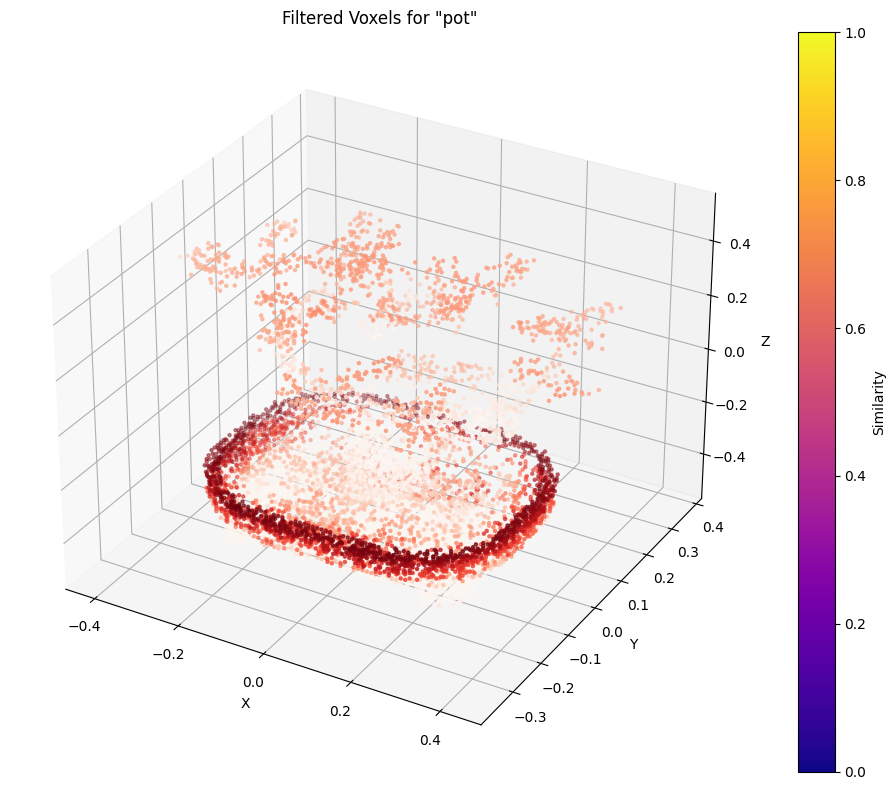

In [12]:
main(grid_feature_path, query, output_dir="./filtered_results", device="cuda")

In [13]:
# feature_grid_path = f"{result_dir}/clip_features_features.npy"
# features = np.load(feature_grid_path)
# features.shape

In [14]:
# from f3rm.pca_colormap import apply_pca_colormap

# # This function should be modified to work on a list of features rather than the full grid
# pca_colors = apply_pca_colormap(torch.from_numpy(features).float(), niter=10)
# print("PCA colors shape:", pca_colors.shape)

In [15]:
# pca_colors

In [16]:

# def visualize_pca_colors(pca_colors, alphas, min_bounds, max_bounds, grid_shape, alpha_threshold=0.01, gray_threshold=0.05):
#     """
#     Visualize the PCA colors of the voxel grid.
    
#     Args:
#         pca_colors: Tensor of shape (grid_shape) containing PCA-derived colors
#         alphas: Tensor of shape (grid_shape) containing density values
#         min_bounds: Minimum bounds of the voxel grid
#         max_bounds: Maximum bounds of the voxel grid
#         grid_shape: Shape of the voxel grid
#         alpha_threshold: Threshold for density values
#         gray_threshold: Threshold for filtering out gray background
#     """
#     device = pca_colors.device
    
#     # Create coordinate grid
#     print("Creating coordinate grid...")
#     x = torch.linspace(min_bounds[0], max_bounds[0], grid_shape[0], device=device)
#     y = torch.linspace(min_bounds[1], max_bounds[1], grid_shape[1], device=device)
#     z = torch.linspace(min_bounds[2], max_bounds[2], grid_shape[2], device=device)
    
#     grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
#     coords = torch.stack([grid_x, grid_y, grid_z], dim=-1)
    
#     # Flatten everything for processing
#     coords_flat = coords.reshape(-1, 3)
#     alphas_flat = torch.from_numpy(alphas).to(device).reshape(-1)
#     pca_colors_flat = pca_colors.reshape(-1, 3)
    
#     # Apply density thresholding
#     print(f"Applying density threshold {alpha_threshold}...")
#     density_mask = alphas_flat > alpha_threshold
#     coords_filtered = coords_flat[density_mask]
#     colors_filtered = pca_colors_flat[density_mask]
    
#     print(f"After density filtering: {len(coords_filtered)} points")
    
#     # Visualize
#     fig = plt.figure(figsize=(12, 10))
#     ax = fig.add_subplot(111, projection='3d')
    
#     points = coords_filtered.cpu().numpy()
#     colors = colors_filtered.cpu().numpy()
    
#     # Normalize colors to [0, 1] range if needed
#     if colors.max() > 1.0:
#         colors = colors / colors.max()
    
#     ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=2)
#     ax.set_title('PCA Color Visualization of Voxel Grid')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
    
#     plt.tight_layout()
#     return fig

# # Visualize the PCA colors
# min_bounds = feature_result['min_bounds']
# max_bounds = feature_result['max_bounds']
# grid_shape = pca_colors.shape[:3]

# fig = visualize_pca_colors(pca_colors, alphas, min_bounds, max_bounds, grid_shape)
# plt.show()